In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import utils, callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Add, Input, ZeroPadding2D, AveragePooling2D,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.layers.merge import concatenate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
from glob import glob
from numpy import floor
import numpy as np
import random
from numpy.random import seed
seed(1)

ASL Alphabet for letter: S


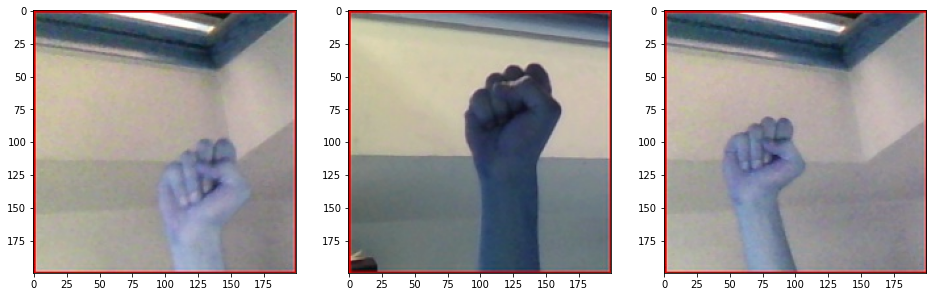

In [2]:
def plot_three_samples(letter):
    print("ASL Alphabet for letter: "+letter)
    base_path = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents,3)
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(1,3,3)
    plt.imshow(cv2.imread(imgs[2]))
    
    return

plot_three_samples('S')

In [3]:
import pandas as pd
from pathlib import Path
import os.path
dir_ = Path('../input/asl-alphabet/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [4]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['W' 'del' 'G' 'X' 'Y' 'space' 'K' 'I' 'H' 'E' 'P' 'J' 'nothing' 'Q' 'S'
 'A' 'C' 'T' 'L' 'M' 'N' 'F' 'B' 'D' 'R' 'O' 'Z' 'V' 'U']


,Filepath,Label
0,../input/asl-alphabet/asl_alphabet_train/asl_a...,W
1,../input/asl-alphabet/asl_alphabet_train/asl_a...,del
2,../input/asl-alphabet/asl_alphabet_train/asl_a...,G
3,../input/asl-alphabet/asl_alphabet_train/asl_a...,X
4,../input/asl-alphabet/asl_alphabet_train/asl_a...,Y


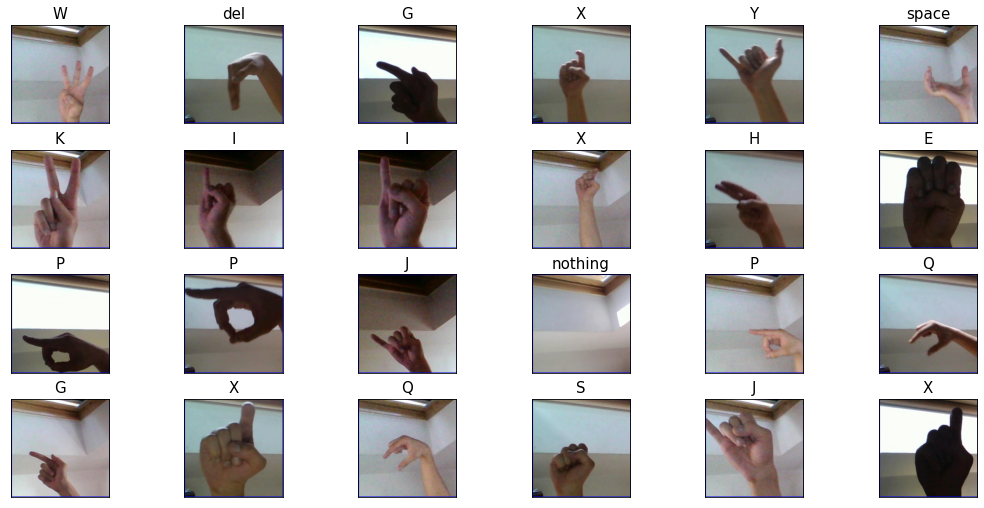

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

In [7]:
target_size = (64,64)
target_dims = (64,64,3)
val_frac = 0.1
n_classes = 29
batch_size = 64

image_generator = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True, validation_split=val_frac)

train_gen = image_generator.flow_from_dataframe(dataframe=train_df, target_size=target_size, x_col = 'Filepath', y_col = 'Label',
                                    class_mode = 'categorical',batch_size=batch_size, shuffle=True, subset='training')

val_gen = image_generator.flow_from_dataframe(dataframe=train_df, target_size=target_size, x_col='Filepath',
        y_col='Label',shuffle=True, subset='validation')

test_gen = image_generator.flow_from_dataframe(dataframe=test_df, x_col='Filepath',
        y_col='Label', target_size=target_size, shuffle=False)

Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [8]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPooling2D((2,2), padding='same')(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPooling2D((2,2), padding='same')(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [9]:
input_shape = (64, 64, 3)

X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2), padding='same')(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5 - stage
X = res_block(X, filter= [512,512,2048], stage= 5)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling', padding='same')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(29, activation = 'softmax')(X)


my_model = Model( inputs= X_input, outputs = X)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
my_model.compile(loss = "categorical_crossentropy", optimizer = adam , metrics = ['accuracy'])

In [12]:
lr_scheduler = LearningRateScheduler(scheduler)
earlystopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5, restore_best_weights=True)

In [13]:
history = my_model.fit(train_gen, validation_data=val_gen, batch_size = 32,
                       epochs = 20, callbacks=[earlystopping, lr_scheduler])

Epoch 1/20
1102/1102 [==============================] - 465s 416ms/step - loss: 2.5781 - accuracy: 0.2740 - val_loss: 0.5289 - val_accuracy: 0.8089
Epoch 2/20
1102/1102 [==============================] - 133s 121ms/step - loss: 0.4992 - accuracy: 0.8253 - val_loss: 0.2713 - val_accuracy: 0.9101
Epoch 3/20
1102/1102 [==============================] - 132s 120ms/step - loss: 0.2338 - accuracy: 0.9214 - val_loss: 0.2163 - val_accuracy: 0.9258
Epoch 4/20
1102/1102 [==============================] - 133s 121ms/step - loss: 0.1575 - accuracy: 0.9472 - val_loss: 0.1464 - val_accuracy: 0.9549
Epoch 5/20
1102/1102 [==============================] - 134s 122ms/step - loss: 0.1184 - accuracy: 0.9622 - val_loss: 0.0497 - val_accuracy: 0.9847
Epoch 6/20
1102/1102 [==============================] - 135s 123ms/step - loss: 0.0807 - accuracy: 0.9744 - val_loss: 0.0666 - val_accuracy: 0.9762
Epoch 7/20
1102/1102 [==============================] - 136s 123ms/step - loss: 0.0748 - accuracy: 0.9773 - val_

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

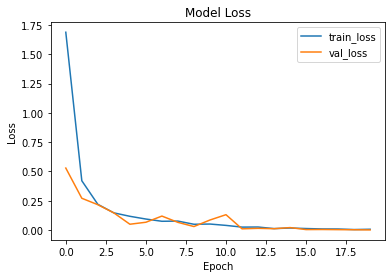

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

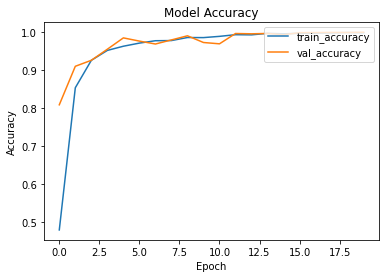

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'upper right')
plt.show()

In [17]:
pred = my_model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

print(acc)

0.9995402298850574


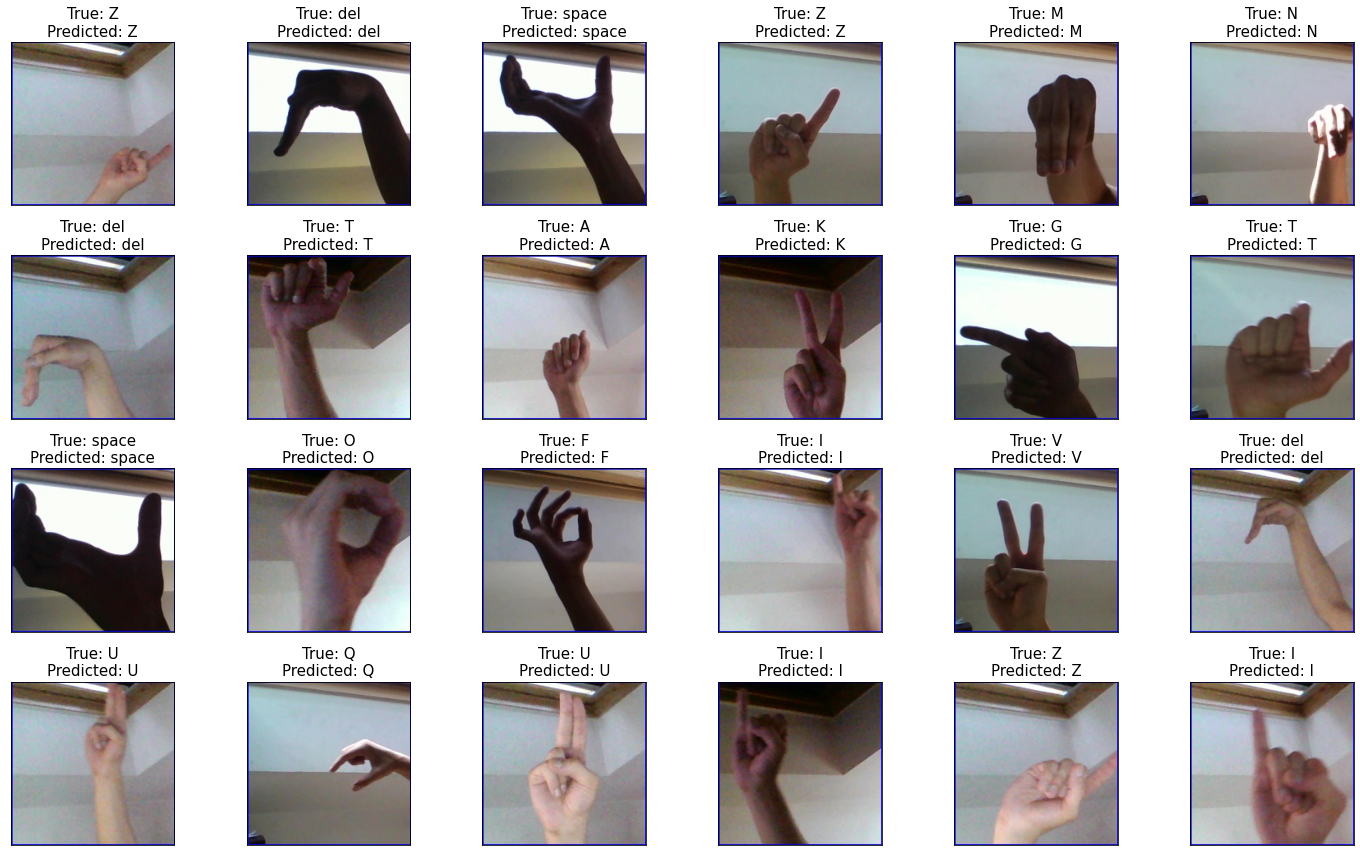

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()